# **Content Extraction using YoloV7**

## Downloading YOLO V7

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! git clone https://github.com/WongKinYiu/yolov7.git
%cd yolov7
!pip install -r /content/yolov7/requirements.txt

Cloning into 'yolov7'...
remote: Enumerating objects: 963, done.
remote: Total 963 (delta 0), reused 0 (delta 0), pack-reused 963
Receiving objects: 100% (963/963), 68.16 MiB | 28.52 MiB/s, done.
Resolving deltas: 100% (503/503), done.
/content/yolov7
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 5.1 MB/s 


## Downloading the Dataset

In [ ]:
!pip install roboflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 145 kB 5.1 MB/s 
     |████████████████████████████████| 178 kB 43.6 MB/s 
     |████████████████████████████████| 1.1 MB 64.2 MB/s 
     |████████████████████████████████| 67 kB 7.1 MB/s 
     |████████████████████████████████| 54 kB 3.4 MB/s 
     |████████████████████████████████| 138 kB 77.6 MB/s 
     |████████████████████████████████| 62 kB 1.8 MB/s 
  Created wheel for roboflow: filename=roboflow-0.2.15-py3-none-any.whl size=24936 sha256=977eeed764fd60560b86abe41090117d3ac4cab2d990b24529f021d56bde2778
  Stored in directory: /root/.cache/pip/wheels/13/e0/a3/fe183fffc3972cb9264e800763d4bbfff80d5309137c410217
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=aa3c33deef9fef41b845c00509176182949bfd455f72b42dc68e286c3594b9a2
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e

In [ ]:
%cd yolov7

/content/yolov7


In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="PP0fWv8m8YLIwLEohnFX")
project = rf.workspace("seusl").project("text-extractor")
dataset = project.version(3).download("yolov7")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Text-Extractor-3 in yolov7pytorch:: 100%|██████████| 298/298 [00:00<00:00, 582.28it/s]


## EDA

{'bulleted_paragraph': 18, 'header': 97, 'page_number': 106, 'paragraph': 582, 'title': 115}


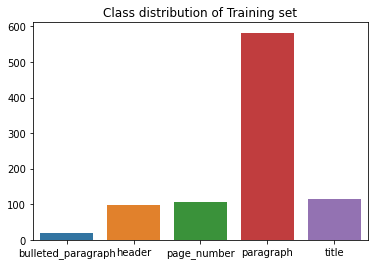

In [ ]:
import yaml
import seaborn as sns
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

DATASET_PATH = '/content/yolov7/Text-Extractor-3'
dataset_yaml = '/content/yolov7/Text-Extractor-3/data.yaml'
train_ann_path = os.path.join(DATASET_PATH,'train','labels')
val_ann_path = os.path.join(DATASET_PATH,'valid','labels')

with open(dataset_yaml) as f:
    my_dict = yaml.safe_load(f)
    train_img_path = my_dict['train']
    val_img_path = my_dict['val']
    nc = my_dict['nc']
    class_names = my_dict['names']

def plot_classes(ann_path, title):
    class_counts = {name:0 for name in class_names}

    for ann_file in os.listdir(ann_path):
        ann_file_path = os.path.join(ann_path, ann_file)
        with open(ann_file_path) as f:
            for line in f.read().split('\n'):
                
                try:
                    class_name = class_names[int(line[0])]
                    class_counts[class_name]=class_counts[class_name]+1
                except:
                    print('failed:', ann_file_path)

    keys = list(class_counts.keys())
    vals = [float(class_counts[k]) for k in keys]
    sns.barplot(x=keys, y=vals).set(title=title)
    return class_counts

print(plot_classes(train_ann_path, 'Class distribution of Training set'))

{'bulleted_paragraph': 2, 'header': 21, 'page_number': 22, 'paragraph': 113, 'title': 23}


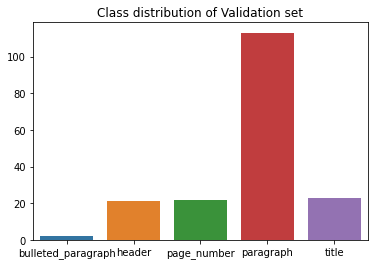

In [ ]:
print(plot_classes(val_ann_path, 'Class distribution of Validation set'))

In [ ]:
!python train.py --workers 8 --device 0 --batch-size 10 --data /content/yolov7/Text-Extractor-3/data.yaml --img 640 640 --cfg /content/yolov7/cfg/training/yolov7.yaml --weights 'yolov7.pt' --name yolov7-custom --hyp data/hyp.scratch.custom.yaml

YOLOR 🚀 v0.1-112-g55b90e1 torch 1.12.1+cu113 CUDA:0 (Tesla T4, 15109.75MB)

Namespace(adam=False, artifact_alias='latest', batch_size=10, bbox_interval=-1, bucket='', cache_images=False, cfg='/content/yolov7/cfg/training/yolov7.yaml', data='/content/yolov7/Text-Extractor-3/data.yaml', device='0', entity=None, epochs=300, evolve=False, exist_ok=False, freeze=[0], global_rank=-1, hyp='data/hyp.scratch.custom.yaml', image_weights=False, img_size=[640, 640], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='yolov7-custom', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/yolov7-custom', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=10, upload_dataset=False, v5_metric=False, weights='yolov7.pt', workers=8, world_size=1)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weigh

## Evaluating the model

In [ ]:
!python test.py --data /content/yolov7/Text-Extractor-3/data.yaml --img 640 --batch 10 --conf 0.001 --iou 0.65 --device 0 --weights /content/drive/MyDrive/best.pt --name yolov7_640_val

Namespace(augment=False, batch_size=10, conf_thres=0.001, data='/content/yolov7/Text-Extractor-3/data.yaml', device='0', exist_ok=False, img_size=640, iou_thres=0.65, name='yolov7_640_val', no_trace=False, project='runs/test', save_conf=False, save_hybrid=False, save_json=False, save_txt=False, single_cls=False, task='val', v5_metric=False, verbose=False, weights=['/content/drive/MyDrive/best.pt'])
YOLOR 🚀 v0.1-112-g55b90e1 torch 1.12.1+cu113 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 314 layers, 36503348 parameters, 6194944 gradients, 103.2 GFLOPS
 Convert model to Tra

In [ ]:
!python detect.py --weights /content/drive/MyDrive/best.pt --conf 0.25 --img-size 640 --source /content/yolov7/Text-Extractor-3/test/images/deeplearningbook-035_jpg.rf.45d3b52d92bb46aa9803d2b584e1c47a.jpg

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', no_trace=False, nosave=False, project='runs/detect', save_conf=False, save_txt=False, source='/content/yolov7/Text-Extractor-3/test/images/deeplearningbook-035_jpg.rf.45d3b52d92bb46aa9803d2b584e1c47a.jpg', update=False, view_img=False, weights=['/content/drive/MyDrive/best.pt'])
YOLOR 🚀 v0.1-112-g55b90e1 torch 1.12.1+cu113 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 314 layers, 36503348 parameters, 6194944 gradients, 103.2 GFLOP

# Prediction

In [ ]:
# Plotting function
def plot_boxes(img, boxes_df):
    bgr_img = img.copy()
    for box in boxes_df.to_numpy():
        xmin, ymin, xmax, ymax, confidence, _, cls_name = box
        xmin, ymin, xmax, ymax, confidence = int(xmin), int(ymin), int(xmax), int(ymax), np.round(confidence, 2)
        txt = str(confidence*100)+'%' + ' ' + cls_name
        labelSize = cv2.getTextSize(txt, cv2.FONT_HERSHEY_SIMPLEX, 0.65, 2)
        ((lw, lh), _) = labelSize
        lh = lh + 10
        bgr_img = cv2.rectangle(bgr_img, (xmin, ymin - lh), (xmin + lw, ymin), [255, 0, 0], -1)
        bgr_img = cv2.rectangle(bgr_img, (xmin, ymin), (xmax, ymax), [255, 0, 0], 2)
        bgr_img = cv2.putText(bgr_img, txt, (xmin, ymin - 9), cv2.FONT_HERSHEY_SIMPLEX, 0.6, [255, 255, 255], 2,
                              cv2.LINE_AA)

    rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)

    return bgr_img, rgb_img

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

model = torch.hub.load('WongKinYiu/yolov7', 'custom', '/content/drive/MyDrive/best.pt')

Using cache found in /root/.cache/torch/hub/WongKinYiu_yolov7_main
/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Adding autoShape... 


In [ ]:
import numpy as np
im = cv2.imread('/content/yolov7/Text-Extractor-3/test/images/deeplearningbook-441_jpg.rf.ff0588d23cfb6966cc4c1764c5d591e8.jpg')
results = model(im)
df = results.pandas().xyxy[0]
bgr, rgb = plot_boxes(im, df)
df

,xmin,ymin,xmax,ymax,confidence,class,name
0,177.564148,472.189789,1465.932983,1010.153442,0.972253,3,paragraph
1,177.403671,193.871445,1459.667114,461.470062,0.971783,3,paragraph
2,178.040985,1418.493896,1472.140015,1905.295044,0.965636,3,paragraph
3,175.191483,1177.567261,1469.102661,1400.885742,0.957322,3,paragraph
4,793.718262,1977.142944,853.850586,2014.286987,0.875786,2,page_number
5,191.050674,1068.832275,1373.407471,1136.890747,0.647472,4,title
6,171.910614,63.991802,1451.633179,132.311493,0.277534,1,header


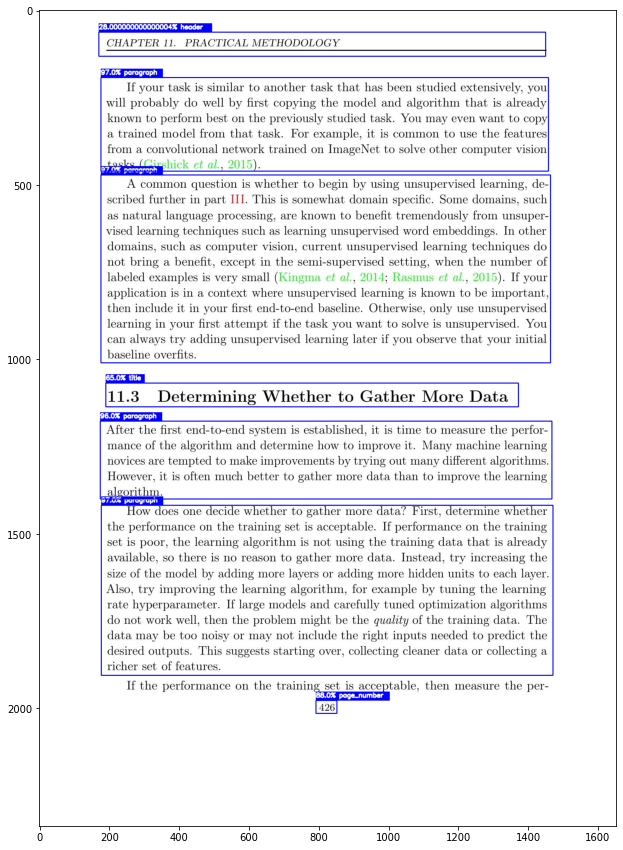

In [ ]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,15)
plt.imshow(rgb)

# Text Extraction with Tesseract

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 20 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (8,336 kB/s)
debconf: unable to initi

In [ ]:
import pytesseract
from PIL import Image
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

model = torch.hub.load('WongKinYiu/yolov7', 'custom', '/content/drive/MyDrive/best.pt')
image_for_ex = cv2.imread('/content/yolov7/Text-Extractor-3/test/images/deeplearningbook-441_jpg.rf.ff0588d23cfb6966cc4c1764c5d591e8.jpg')
results = model(image_for_ex)
detections = results.pandas().xyxy[0].to_numpy()
detections

detection_dict = {}
for i, detection in enumerate(detections):
  xmin, ymin, xmax, ymax, conf, cls_num, cls_name = detection
  xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
  cropped_img = image_for_ex[ymin:ymax, xmin:xmax]
  cv2.imwrite("temp.jpg",cropped_img)
  extractedInformation = pytesseract.image_to_string(Image.open("temp.jpg"))
  det_name = cls_name +" "+ str(i)
  detection_dict[det_name]=extractedInformation

detection_dict

Using cache found in /root/.cache/torch/hub/WongKinYiu_yolov7_main
/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Adding autoShape... 


{'paragraph 0': 'A common question is whether to begin by using unsupervised learning, de-\nscribed further in part III. This is somewhat domain specific. Some domains, such\nas natural language processing, are known to benefit tremendously from unsuper-\nvised learning techniques such as learning unsupervised word embeddings. In other\ndomains, such as computer vision, current unsupervised learning techniques do\nnot bring a benefit, except in the semi-supervised setting, when the number of\nlabeled examples is very small (Kingma et al., 2014; Rasmus et al., 2015). If your\napplication is in a context where unsupervised learning is known to be important,\nthen include it in your first end-to-end baseline. Otherwise, only use unsupervised\nlearning in your first attempt if the task you want to solve is unsupervised. You\ncan always try adding unsupervised learning later if you observe that your initial\nbaseline overfits.\n\x0c',
 'paragraph 1': 'If your task is similar to another task